# QOSF - Task 1

Implement, on a quantum simulator of your choice, the following 4 qubits state |()>:
Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


Even blocks


Odd blocks


The angles i, nare variational parameters, lying in the interval (0, 2), initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$\varepsilon = \min_{\theta} || |\psi(\theta)> - |\phi> ||$

Where |$\phi$> is a randomly generated vector on 4 qubits and the norm || |v> ||, of a state |v>, simply denotes the sum of the squares of the components of |v>. The right set of parameters i,n can be found via any method of choice (e.g. grid-search or gradient descent)


---

### Bonus question:
Try using other gates for the parametrized gates and see what happens.


# TODO
- [x] Ensure initial random vector is the same for all optimizers, just to be fair
- [ ] Tests
- [ ] Write docs and references
- [ ] Optimize optimizer parameters, eta's, tolerances, etc.
- [ ] Run it once with 1000 iterations, and go for lunch, and hope jupyter doesn't die
- [x] Benchmark execution time for each optimizer
- [ ] Find parameters with dwave and compare, perhaps?
- [ ] Add a noise model to the simulator and reevaluate results
- [ ] Bonus question

## Environment setup

In [1]:
#pip3 install qiskit, numpy, matplotlib

import qiskit
import numpy as np
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, execute, quantum_info
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## Approach
We will use the defined "odd" and "even" gates in steps defined by "Layers". With Rx gates for the odd blocks, and Rz's and full entanglement for the even blocks.

All gates in each block have the same theta rotation, therefore the variational parameters will be 2*Layers. (One for the odd and one for the even blocks).

We will first create the circuit in a way that we can call it individually from a cost function. We will first use a random parameter algorithm to have a benchmark, an compare with COBYLA, SPSA and AQBD. In further iterations we can try optimizing the hyperparameters of each optimizer and add other algorithms.

## Initial constants

#### Stuff you can change
L = Layers, or iterations of odd / even unitary gates

N_QUBITS = Number of Qubits for the unitary gates

ITERATIONS =  Number of iterations for each optimizer. The more, the merrier, and the hotter your CPU


#### Better not change this
CURRENT_LAYER = Constant to update the layers for each iteration

PHI = Target vector, initialited randomly for comparison

THETAS = Random initial Thetas. Array for all possible values depending on the number of layers

CALCULATiON_TIMES = Just a list to store the execution times for each optimizer to compare later on


In [2]:
def calculate_random_theta():
    return np.random.uniform(0, 2*np.pi)

def get_random_thetas(layers):
    thetas = []
    for i in range(layers):
        thetas.append(calculate_random_theta())
    return thetas

In [3]:
L = 10
N_QUBITS = 4
ITERATIONS = 500 # Iterations for each step in each opimizer. Start with 50 to test. Then increase gradually and go for a (long) coffee


CURRENT_LAYER = 0
PHI = quantum_info.random_statevector(2**N_QUBITS)
# Calculate ALL Thetas at the beginning so we can use the same random initial vector for all optimizers
for i in range(L):
    THETAS = get_random_thetas(L * 2)

CALCULATION_TIMES = {}
backend = Aer.get_backend("qasm_simulator")

### Preparing the Circuit
Adding functions to create unitary gates, calculate random theta angles for each layers and finally create and run the variational circuit.

We use the statevetor simulator to compare with the initial random phi. And create the objective (cost) function to minimize using the norm between psi(theta) and phi.

In [4]:
# Unitary 4 Qubit gate with Rz's full entanglement
def even_gate(theta, index, qubits):
    name = "Ue"+str(index)+"("+str(theta)+")"
    u_even = QuantumCircuit(len(qubits), name=name)
    u_even.rz(theta,qubits)

    for t in qubits:
        i = t
        for z in range(len(qubits)-t-1):
            u_even.cz(t, i + 1)
            i += 1

    return u_even

# Unitary 4 Qubit gate with Rx's and no entanglement
def odd_gate(theta, index, qubits):
    name = "Uo"+str(index)+"("+str(theta)+")"
    u_odd = QuantumCircuit(len(qubits), name=name)
    u_odd.ry(theta, qubits)

    return u_odd

In [5]:
def get_variational_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    
    qubits = [i for i in range(n_qubits)]
    circuit = QuantumCircuit(n_qubits)
    theta = 0
    for i in range(layers):
        circuit.append(even_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        circuit.append(odd_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        
    return circuit

def run_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    circuit = get_variational_circuit(thetas)
    
    simulator = Aer.get_backend("statevector_simulator")
    job = execute(circuit, backend=simulator, shots=1024)
    result = job.result()
    
    return result.get_statevector(circuit)

def objective_function(thetas):
    psi_theta = run_circuit(thetas)
    cost = np.linalg.norm(psi_theta - PHI.data)
    return cost

In [6]:
# Test the Circuit to make sure everything is ok, and thetas are properly applied
CURRENT_LAYER = 2
circuit = get_variational_circuit(THETAS)
circuit.draw()

┌──────────────────────────┐┌──────────────────────────┐»
q_0: ┤0                         ├┤0                         ├»
     │                          ││                          │»
q_1: ┤1                         ├┤1                         ├»
     │  Ue0(4.8285226215905945) ││  Uo0(2.0197568703614777) │»
q_2: ┤2                         ├┤2                         ├»
     │                          ││                          │»
q_3: ┤3                         ├┤3                         ├»
     └──────────────────────────┘└──────────────────────────┘»
«     ┌────────────────────────┐┌─────────────────────────┐
«q_0: ┤0                       ├┤0                        ├
«     │                        ││                         │
«q_1: ┤1                       ├┤1                        ├
«     │  Ue1(2.37652536063315) ││  Uo1(2.193441291023336) │
«q_2: ┤2                       ├┤2                        ├
«     │                        ││                         │
«q_3: ┤3                       ├┤3                        ├
«     └────────────────────────┘└─────────────────────────┘

### Getting results

1. Random Thetas
2. COBYLA
3. SPSA
4. AQGD

Results are stored in a specific array so we can plot and copmare them later

In [7]:
random_results = []
start_time = time.time()

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    optimization_results = []    
    
    for i in range(ITERATIONS):
        psi_theta = run_circuit(THETAS)
        optimization_results.append(np.linalg.norm(psi_theta - PHI.data))
    
    distance = min(optimization_results)

    print("Layers: ",layers, "| Distance: ",distance)
    random_results.append(distance)

end_time = time.time()
CALCULATION_TIMES["random"] = end_time - start_time

Layers:  1 | Distance:  1.1390231109476014
Layers:  2 | Distance:  1.501205296872942
Layers:  3 | Distance:  1.4571191770210696
Layers:  4 | Distance:  1.3699565433179675
Layers:  5 | Distance:  1.355451132034527
Layers:  6 | Distance:  1.4985828707391713
Layers:  7 | Distance:  1.4332857015614484
Layers:  8 | Distance:  1.4985435298639591
Layers:  9 | Distance:  1.396624863021791
Layers:  10 | Distance:  1.362204044270325


In [8]:
## Trial with COBYLA
from qiskit.aqua.components.optimizers import COBYLA

cobyla_results = []
start_time = time.time()
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["COBYLA"] = end_time - start_time

Layers:  1 | Distance:  1.1354898044493635
Layers:  2 | Distance:  1.1105013010072629
Layers:  3 | Distance:  0.9653654140542526
Layers:  4 | Distance:  0.970369101446781
Layers:  5 | Distance:  0.9484974600702607
Layers:  6 | Distance:  0.9480936795151343
Layers:  7 | Distance:  0.9482797576750223
Layers:  8 | Distance:  0.9478055052453016
Layers:  9 | Distance:  0.9483670168482929
Layers:  10 | Distance:  0.9478570908270783


In [9]:
## Trial with SPSA
from qiskit.aqua.components.optimizers import SPSA

spsa_results = []
start_time = time.time()
optimizer = SPSA(maxiter=ITERATIONS, c0=0.03, c1=0.01)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    spsa_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["SPSA"] = end_time - start_time

Layers:  1 | Distance:  1.135489822768717
Layers:  2 | Distance:  1.1531474815217755
Layers:  3 | Distance:  1.125980039395277
Layers:  4 | Distance:  1.0090165794398906
Layers:  5 | Distance:  1.0943960791762053
Layers:  6 | Distance:  1.5009509439326765
Layers:  7 | Distance:  1.3477587088382759
Layers:  8 | Distance:  1.2509326748047775
Layers:  9 | Distance:  1.4041924526617793
Layers:  10 | Distance:  1.460274184555091


In [10]:
## Trial with AQGD
from qiskit.aqua.components.optimizers import AQGD

aqgd_results = []
start_time = time.time()
optimizer = AQGD(maxiter=ITERATIONS, tol=0.0001, eta=0.9, momentum=0.9)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    aqgd_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["AQGD"] = end_time - start_time

Layers:  1 | Distance:  1.13549227450455
Layers:  2 | Distance:  1.1309694341204737
Layers:  3 | Distance:  1.0709285397130257
Layers:  4 | Distance:  1.0980565781492515
Layers:  5 | Distance:  1.0477149314278
Layers:  6 | Distance:  1.1217264287521433
Layers:  7 | Distance:  1.0370823308873895
Layers:  8 | Distance:  1.0946945280902889
Layers:  9 | Distance:  1.0955231848464346
Layers:  10 | Distance:  1.078568495511071


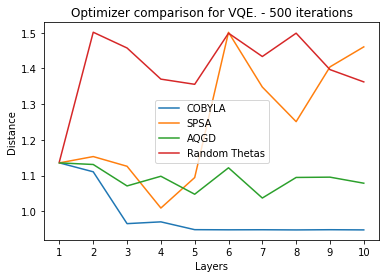

In [11]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
plt.plot(x_axis, cobyla_results, label="COBYLA")
plt.plot(x_axis, spsa_results, label="SPSA")
plt.plot(x_axis, aqgd_results, label="AQGD")
plt.plot(x_axis, random_results, label="Random Thetas")
plt.title('Optimizer comparison for VQE. - '+ str(ITERATIONS) +" iterations")
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')
plt.savefig('RxRy VQE_compare_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'.png')


In [12]:
print(CALCULATION_TIMES)

{'random': 308.33132815361023, 'COBYLA': 245.66655898094177, 'SPSA': 624.3007831573486, 'AQGD': 12349.435942173004}


<BarContainer object of 4 artists>

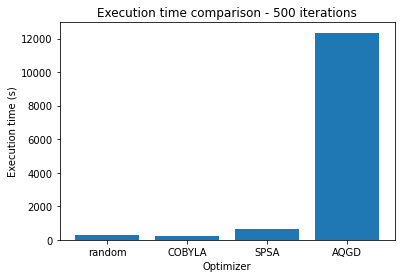

In [13]:
# Plot execution timmes performance
keys = CALCULATION_TIMES.keys()
values = CALCULATION_TIMES.values()

plt.xlabel('Optimizer')
plt.ylabel('Execution time (s)')
plt.title('Execution time comparison - '+ str(ITERATIONS) +" iterations")
plt.bar(keys, values)